In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer,IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn import model_selection

In [ ]:

data = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/datasets/inhability_dataset/train.csv")
data.head()
test=pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/datasets/inhability_dataset/test.csv")

In [ ]:
print("--------------------------Dataset Information------------------")
print(data.info())
print("\n------------data types : ----------------\n",data.dtypes)
print("\n------------ missing values: ----------------\n",data.isnull().sum())
print("\n------------data duplicated values : ----------------\n",data.duplicated())
print("\n------------unique values : ----------------\n",data.apply(lambda col: col.unique()))

--------------------------Dataset Information------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39499 entries, 0 to 39498
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Property_ID             39499 non-null  object 
 1   Property_Type           39499 non-null  object 
 2   Property_Area           39499 non-null  int64  
 3   Number_of_Windows       37845 non-null  float64
 4   Number_of_Doors         39499 non-null  int64  
 5   Furnishing              38457 non-null  object 
 6   Frequency_of_Powercuts  38116 non-null  float64
 7   Power_Backup            39499 non-null  object 
 8   Water_Supply            39499 non-null  object 
 9   Traffic_Density_Score   39499 non-null  float64
 10  Crime_Rate              38712 non-null  object 
 11  Dust_and_Noise          38280 non-null  object 
 12  Air_Quality_Index       39499 non-null  float64
 13  Neighborhood_Review     394

In [ ]:
data_cat_col=[col for col in data.columns if data[col].dtypes=='object']
data_float_col=[col for col in data.columns if data[col].dtypes=='float64']
data_int_col=[col for col in data.columns if data[col].dtypes == 'int64']
print("categorical columns : ",data_cat_col)
print("float columns : ",data_float_col)
print("int columns : ",data_int_col)

categorical columns :  ['Property_ID', 'Property_Type', 'Furnishing', 'Power_Backup', 'Water_Supply', 'Crime_Rate', 'Dust_and_Noise']
float columns :  ['Number_of_Windows', 'Frequency_of_Powercuts', 'Traffic_Density_Score', 'Air_Quality_Index', 'Neighborhood_Review', 'Habitability_score']
int columns :  ['Property_Area', 'Number_of_Doors']


In [ ]:
(data.describe())

,Property_Area,Number_of_Windows,Number_of_Doors,Frequency_of_Powercuts,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Habitability_score
count,39499.000000,37845.000000,39499.000000,38116.000000,39499.000000,39499.000000,39499.000000,39499.000000
mean,1391.715638,3.923768,2.331375,0.484678,6.354772,121.352566,3.735945,73.482297
std,1953.287544,2.690992,1.179964,0.752207,1.219681,62.384669,0.796843,14.118753
min,100.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.280000
25%,494.000000,2.000000,1.000000,0.000000,5.600000,95.000000,3.220000,69.660000
50%,932.000000,4.000000,2.000000,0.000000,6.470000,113.000000,3.850000,75.760000
75%,1770.000000,5.000000,3.000000,1.000000,7.220000,140.000000,4.260000,82.260000
max,28064.000000,15.000000,6.000000,3.000000,9.910000,1044.000000,5.000000,100.000000


In [ ]:
# THE DATASET CONTAINES 5 COLUMNS THAT HAS MISSING VALUES IN IT.
# SO OUT FIRST FOCUS WILL BE HOW TO HANDALING MISSING VALUES 
def shows_missing_values(data):
  print("==========columns that has missing values =========")
  for col in data.columns:
    if data[col].isnull().sum() > 0:
      print(col,":",data[col].isnull().sum(),"   type of data : ",data[col].dtypes)
      print("unique values : ",data[col].unique())
      print("--------------------------------------------------")
shows_missing_values(data)

==========columns that has missing values =========
Number_of_Windows : 1654    type of data :  float64
unique values :  [nan  2.  4.  3. 14.  5.  1. 13.  6.  7.  9. 15. 11. 12.  0.  8. 10.]
--------------------------------------------------
Furnishing : 1042    type of data :  object
unique values :  ['Semi_Furnished' 'Unfurnished' 'Fully Furnished' nan]
--------------------------------------------------
Frequency_of_Powercuts : 1383    type of data :  float64
unique values :  [ 0.  1.  2.  3. nan]
--------------------------------------------------
Crime_Rate : 787    type of data :  object
unique values :  ['Slightly below average' 'Well below average' 'Well above average' nan
 'Slightly above average']
--------------------------------------------------
Dust_and_Noise : 1219    type of data :  object
unique values :  ['Medium' nan 'High' 'Low']
--------------------------------------------------


In [ ]:
print(data['Water_Supply'].unique())
print(data['Power_Backup'].unique())

['Once in a day - Morning' 'Once in a day - Evening' 'All time'
 'NOT MENTIONED' 'Once in two days']
['No' 'Yes' 'NOT MENTIONED']


In [ ]:
def mapping_num_values(data):
  furnishing_map={'Semi_Furnished':1, 'Unfurnished':0 ,'Fully Furnished':2}
  data['Furnishing']=data['Furnishing'].map(furnishing_map)
  crime_rate_map={'Slightly below average':2, 'Well below average':3, 'Well above average':0,'Slightly above average':1}
  data['Crime_Rate']=data['Crime_Rate'].map(crime_rate_map)
  dust_and_noise_map={'Medium':1, 'High':0, 'Low':2}
  data['Dust_and_Noise']=data['Dust_and_Noise'].map(dust_and_noise_map)
  Water_Supply_map={'Once in a day - Morning':1, 'Once in a day - Evening':1, 'All time':2,
 'NOT MENTIONED':np.nan, 'Once in two days':0}
  data['Water_Supply']=data['Water_Supply'].map(Water_Supply_map)
  Power_Backup_map={'No':0, 'Yes':1, 'NOT MENTIONED':np.nan}
  data['Power_Backup']=data['Power_Backup'].map(Power_Backup_map)
  return data
data=mapping_num_values(data)

In [ ]:
shows_missing_values(data)

==========columns that has missing values =========
Number_of_Windows : 1654    type of data :  float64
unique values :  [nan  2.  4.  3. 14.  5.  1. 13.  6.  7.  9. 15. 11. 12.  0.  8. 10.]
--------------------------------------------------
Furnishing : 1042    type of data :  float64
unique values :  [ 1.  0.  2. nan]
--------------------------------------------------
Frequency_of_Powercuts : 1383    type of data :  float64
unique values :  [ 0.  1.  2.  3. nan]
--------------------------------------------------
Power_Backup : 828    type of data :  float64
unique values :  [ 0.  1. nan]
--------------------------------------------------
Water_Supply : 345    type of data :  float64
unique values :  [ 1.  2. nan  0.]
--------------------------------------------------
Crime_Rate : 787    type of data :  float64
unique values :  [ 2.  3.  0. nan  1.]
--------------------------------------------------
Dust_and_Noise : 1219    type of data :  float64
unique values :  [ 1. nan  0.  2.]
--

In [ ]:
def preprocessing(data):
  data.drop(columns=['Property_ID'],inplace=True)
  print(data.info())
  # if train:
  #   print(data['Power_Backup'].unique(), len(data[data['Power_Backup']=='NOT MENTIONED']))
  #   print(data['Water_Supply'].unique(), len(data[data['Water_Supply']=='NOT MENTIONED']))
  #   data.drop(data[data['Water_Supply']=='NOT MENTIONED'].index,inplace=True)
  #   print(data.info())
  #   data.drop(data[data['Power_Backup']=='NOT MENTIONED'].index,inplace=True)
  #   print(data.info())
  return data
data= preprocessing(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39499 entries, 0 to 39498
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Property_Type           39499 non-null  object 
 1   Property_Area           39499 non-null  int64  
 2   Number_of_Windows       37845 non-null  float64
 3   Number_of_Doors         39499 non-null  int64  
 4   Furnishing              38457 non-null  float64
 5   Frequency_of_Powercuts  38116 non-null  float64
 6   Power_Backup            38671 non-null  float64
 7   Water_Supply            39154 non-null  float64
 8   Traffic_Density_Score   39499 non-null  float64
 9   Crime_Rate              38712 non-null  float64
 10  Dust_and_Noise          38280 non-null  float64
 11  Air_Quality_Index       39499 non-null  float64
 12  Neighborhood_Review     39499 non-null  float64
 13  Habitability_score      39499 non-null  float64
dtypes: float64(11), int64(2), object(1)
me

In [ ]:
def one_hot_encoding(col,data):
  # Get one hot encoding of columns B
  one_hot = pd.get_dummies(data[col])
  # Drop column B as it is now encoded
  data = data.drop(col,axis = 1)
  # Join the encoded df
  data = data.join(one_hot)
  return data

In [ ]:
# data=one_hot_encoding('Power_Backup',data)
# data=one_hot_encoding('Water_Supply',data)


In [ ]:
data=one_hot_encoding('Property_Type',data)

In [ ]:
data.head()

,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score,#R%$G&867,Apartment,Bungalow,Container Home,Duplex,Single-family home
0,106,NaN,1,1.0,0.0,0.0,1.0,5.89,2.0,1.0,90.0,3.86,71.98,0,1,0,0,0,0
1,733,2.0,2,0.0,1.0,0.0,1.0,4.37,3.0,1.0,96.0,3.55,71.20,0,1,0,0,0,0
2,737,4.0,2,2.0,0.0,0.0,1.0,7.45,2.0,1.0,121.0,3.81,71.39,0,1,0,0,0,0
3,900,3.0,2,0.0,2.0,1.0,1.0,6.16,0.0,1.0,100.0,1.34,31.46,0,1,0,0,0,0
4,2238,14.0,6,2.0,0.0,0.0,2.0,5.46,3.0,1.0,116.0,4.77,93.70,0,0,1,0,0,0


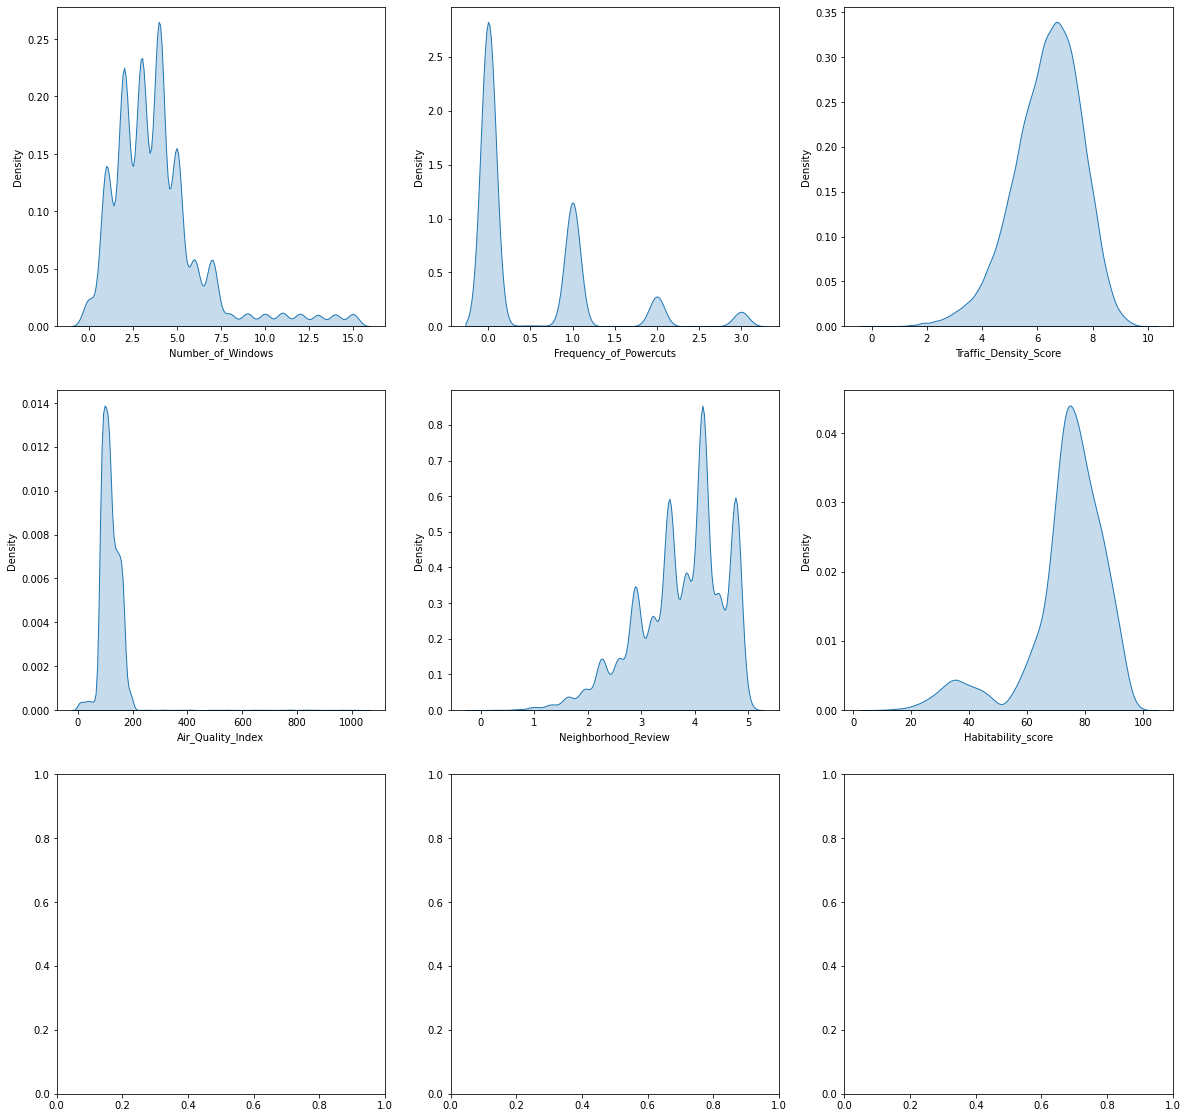

In [ ]:
#float columns distribution
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(20,20))

sns.kdeplot(data=data[data_float_col[0]],ax=ax[0][0],shade=True)
sns.kdeplot(data=data[data_float_col[1]],ax=ax[0][1],shade=True)
sns.kdeplot(data=data[data_float_col[2]],ax=ax[0][2],shade=True)
sns.kdeplot(data=data[data_float_col[3]],ax=ax[1][0],shade=True)
sns.kdeplot(data=data[data_float_col[4]],ax=ax[1][1],shade=True)
sns.kdeplot(data=data[data_float_col[5]],ax=ax[1][2],shade=True)
# sns.kdeplot(data=data[data_float_col[6]],ax=ax[2][0],shade=True)
# sns.kdeplot(data=data[data_float_col[7]],ax=ax[2][1],shade=True)
# sns.kdeplot(data=data[data_float_col[8]],ax=ax[2][2],shade=True)


## **Integer column correlations**

In [ ]:
def unique_values(data):
    for col in data_cat_col[1:]:
        print('*'*50)
        print(f"The unique values in {col} are:")
        print(data[col].unique())

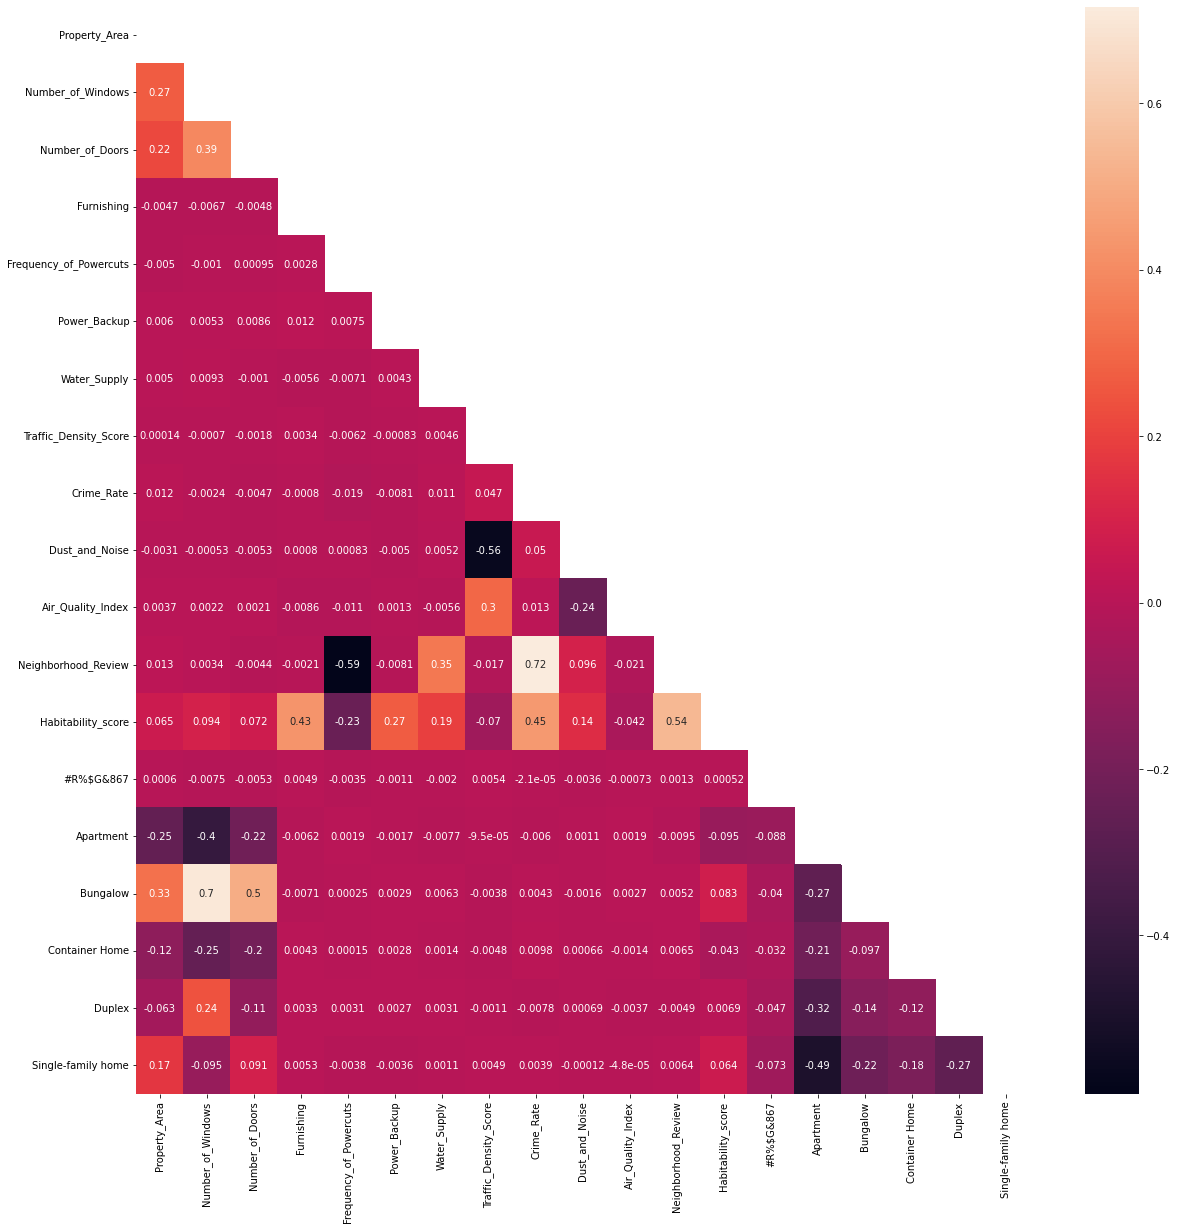

In [ ]:
def get_correlation(data):
  # full feature correlation
  corr= data.corr()

  # Getting the Upper Triangle of the co-relation matrix
  matrix = np.triu(corr)

  plt.figure(figsize=(20,20))
  sns.heatmap(corr,annot=True,mask=matrix)
get_correlation(data)

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor


def tree_imputation(df):
    missing_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
    non_missing_cols = [col for col in df.columns if df[col].isnull().sum() == 0]
    # num_cols = [col for col in missing_cols if df[col].dtype != 'object']

    # df = df[num_cols]
    for col in missing_cols:

        # Defining a new bagging model for each attribute  
        model = BaggingRegressor(DecisionTreeRegressor(), n_estimators = 40, max_samples = 1.0, max_features = 1.0, bootstrap = False, n_jobs = -1)

        col_missing = df[df[col].isnull()]
        temp = df.drop(df[df[col].isnull()].index, axis = 0)

        # print(temp.columns)
        # X = temp.drop(col, axis = 1)
        X = temp.loc[:, non_missing_cols]
        y = temp[col]

        model.fit(X, y)

        y_pred = model.predict(col_missing[non_missing_cols])
        # col_missing[col] = y_pred

        df.loc[col_missing.index, col] = y_pred
        
    return df

In [ ]:
df_new = tree_imputation(data)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39499 entries, 0 to 39498
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Property_Area           39499 non-null  int64  
 1   Number_of_Windows       39499 non-null  float64
 2   Number_of_Doors         39499 non-null  int64  
 3   Furnishing              39499 non-null  float64
 4   Frequency_of_Powercuts  39499 non-null  float64
 5   Power_Backup            39499 non-null  float64
 6   Water_Supply            39499 non-null  float64
 7   Traffic_Density_Score   39499 non-null  float64
 8   Crime_Rate              39499 non-null  float64
 9   Dust_and_Noise          39499 non-null  float64
 10  Air_Quality_Index       39499 non-null  float64
 11  Neighborhood_Review     39499 non-null  float64
 12  Habitability_score      39499 non-null  float64
 13  #R%$G&867               39499 non-null  uint8  
 14  Apartment               39499 non-null

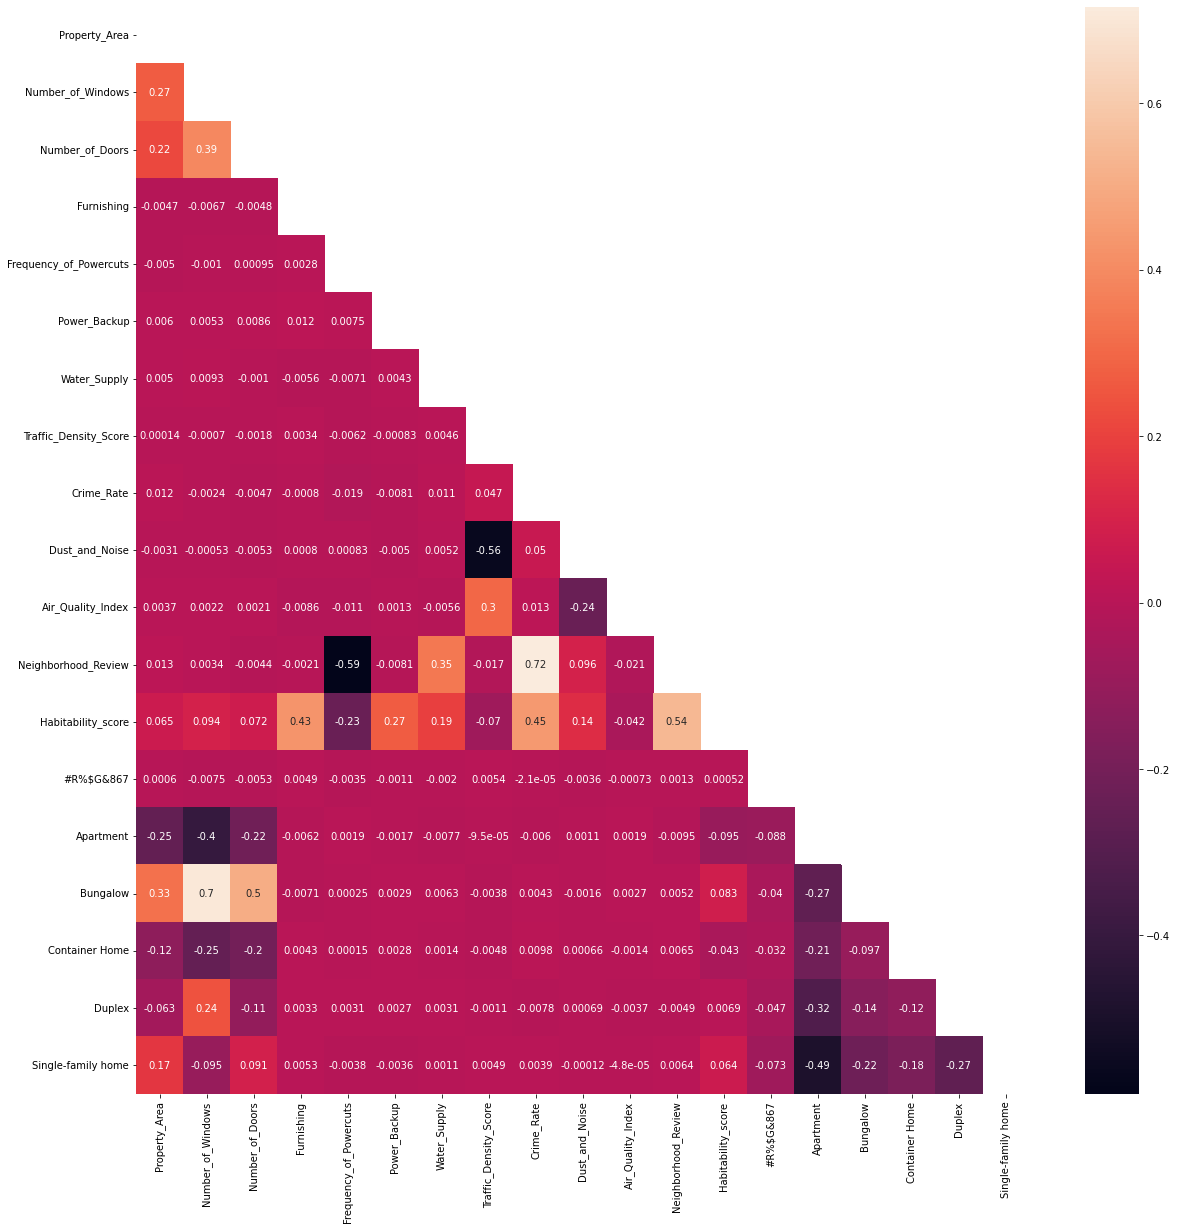

In [ ]:
get_correlation(df_new)

In [ ]:
# now we have training data without any missing values
# next step to create a k folds 
def create_k_folds(df_new,k):
  path=r'/content/drive/MyDrive/Colab Notebooks/datasets/inhability_dataset/'
  # we create a new column called kfold and fill it with -1
  df_new["kfold"] = -1
  # the next step is to randomize the rows of the data
  df_new = df_new.sample(frac=1).reset_index(drop=True)
  # initiate the kfold class from model_selection module
  kf = model_selection.KFold(n_splits=k)
  # fill the new kfold column
  for fold, (trn_, val_) in enumerate(kf.split(X=df_new)):
    df_new.loc[val_, 'kfold'] = fold
  # save the new csv with kfold column
  df_new.to_csv(path+"train_folds.csv", index=False)

In [ ]:
# create_k_folds(df_new,5)

In [ ]:
# data_cleaned=df_new.copy()
data.columns

Index(['Property_Area', 'Number_of_Windows', 'Number_of_Doors', 'Furnishing',
       'Frequency_of_Powercuts', 'Power_Backup', 'Water_Supply',
       'Traffic_Density_Score', 'Crime_Rate', 'Dust_and_Noise',
       'Air_Quality_Index', 'Neighborhood_Review', 'Habitability_score',
       '#R%$G&867', 'Apartment', 'Bungalow', 'Container Home', 'Duplex',
       'Single-family home'],
      dtype='object')

In [ ]:
# extract features with high correlation
# col= ['Habitability_score','Furnishing','Power_Backup', 'Water_Supply','Crime_Rate','Dust_and_Noise','Neighborhood_Review']
# df_extract = df_new[col]
# df_extract.head()

,Habitability_score,Furnishing,Power_Backup,Water_Supply,Crime_Rate,Dust_and_Noise,Neighborhood_Review
0,71.98,1.0,0.0,1.0,2.0,1.0,3.86
1,71.20,0.0,0.0,1.0,3.0,1.0,3.55
2,71.39,2.0,0.0,1.0,2.0,1.0,3.81
3,31.46,0.0,1.0,1.0,0.0,1.0,1.34
4,93.70,2.0,0.0,2.0,3.0,1.0,4.77


In [ ]:
# df_new=df_extract
target = df_new['Habitability_score']
df_new.drop(columns=['Habitability_score'],inplace=True)
print(df_new.shape,target)


(39499, 6) 0        71.98
1        71.20
2        71.39
3        31.46
4        93.70
         ...  
39494    73.43
39495    79.91
39496    81.44
39497    71.33
39498    83.25
Name: Habitability_score, Length: 39499, dtype: float64


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


6 0        71.98
1        71.20
2        71.39
3        31.46
4        93.70
         ...  
39494    73.43
39495    79.91
39496    81.44
39497    71.33
39498    83.25
Name: Habitability_score, Length: 39499, dtype: float64


IndexError: ignored

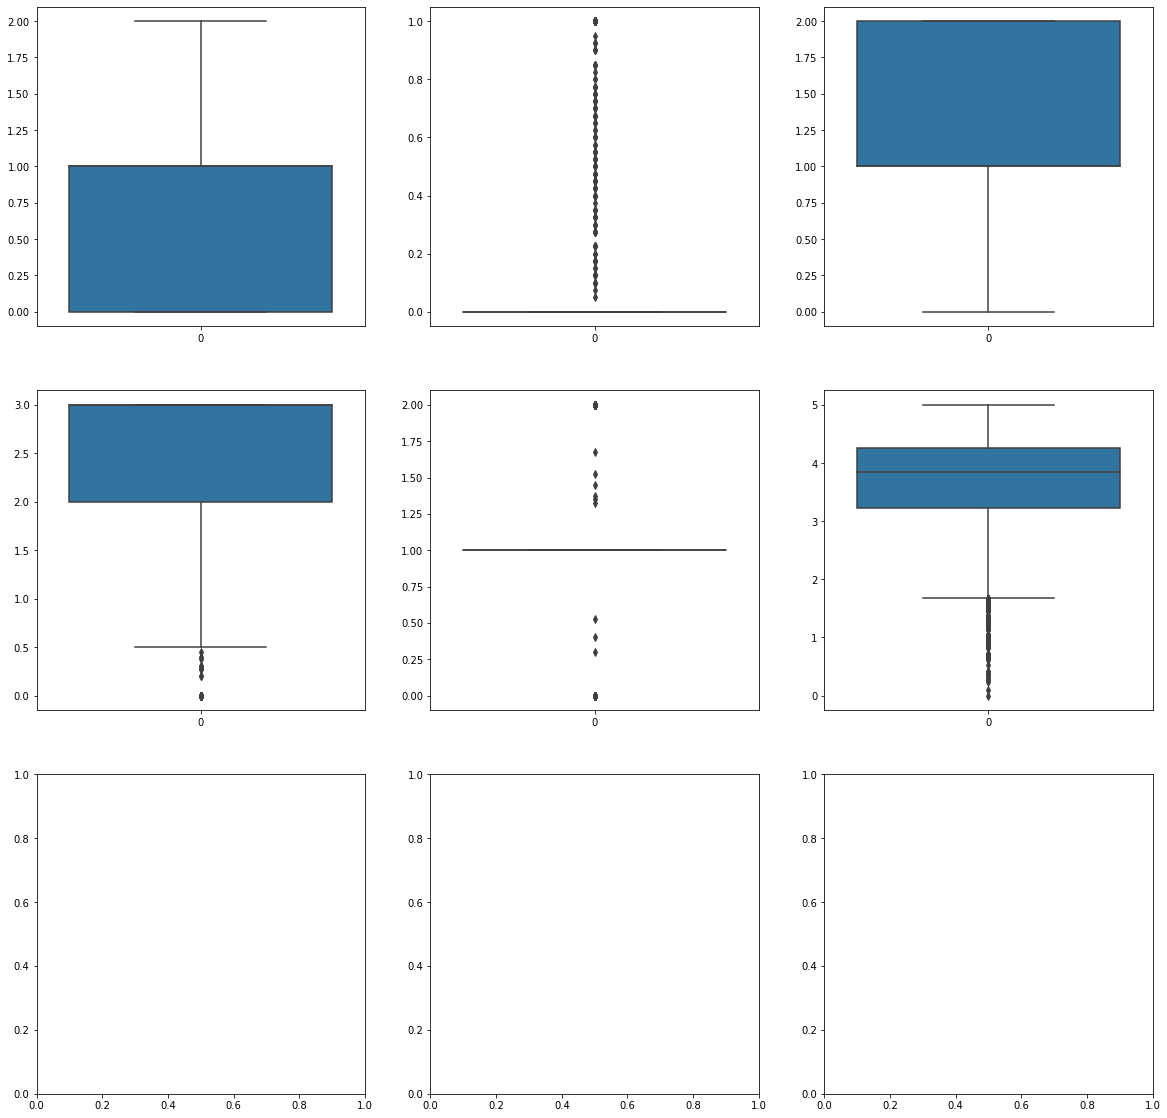

In [ ]:
(print(len(df_new.columns),target))
# find out if there is an outliers in dataset
fig,ax = plt.subplots(nrows=int(len(df_new.columns)/3)+1,ncols=3,figsize=(20,20))

sns.boxplot(data=df_new[df_new.columns[0]],ax=ax[0][0])
sns.boxplot(data=df_new[df_new.columns[1]],ax=ax[0][1])
sns.boxplot(data=df_new[df_new.columns[2]],ax=ax[0][2])
sns.boxplot(data=df_new[df_new.columns[3]],ax=ax[1][0])
sns.boxplot(data=df_new[df_new.columns[4]],ax=ax[1][1])
sns.boxplot(data=df_new[df_new.columns[5]],ax=ax[1][2])
sns.boxplot(data=df_new[df_new.columns[6]],ax=ax[2][0])
sns.boxplot(data=df_new[df_new.columns[7]],ax=ax[2][1])
sns.boxplot(data=df_new[df_new.columns[8]],ax=ax[2][2])
sns.boxplot(data=df_new[df_new.columns[9]],ax=ax[3][0])
sns.boxplot(data=df_new[df_new.columns[10]],ax=ax[3][1])
sns.boxplot(data=df_new[df_new.columns[11]],ax=ax[3][2])
sns.boxplot(data=df_new[df_new.columns[12]],ax=ax[4][0])
sns.boxplot(data=df_new[df_new.columns[13]],ax=ax[4][1])
sns.boxplot(data=df_new[df_new.columns[14]],ax=ax[4][2])
sns.boxplot(data=df_new[df_new.columns[15]],ax=ax[5][0])
sns.boxplot(data=df_new[df_new.columns[16]],ax=ax[5][1])
# sns.boxplot(data=df_new[df_new.columns[18]],ax=ax[5][2])
# sns.boxplot(data=df_new[df_new.columns[19]],ax=ax[6][0])
# sns.boxplot(data=df_new[df_new.columns[20]],ax=ax[6][1])
# sns.boxplot(data=df_new[df_new.columns[21]],ax=ax[6][2])


In [ ]:
# def runfold(n):
#   # first we are going to read the data file:
#   path=r'/content/drive/MyDrive/Colab Notebooks/datasets/inhability_dataset/'
#   data= pd.read_csv(path+"train_folds.csv")

#   train = data[data['kfold']!=n]
#   train_y = train[['Habitability_score']]
#   train_x=train.drop(columns=['Habitability_score'],inplace=True)
#   test=data[data['kfold']==n]

#   # now we are going to normalize the data
#   transformer = RobustScaler()
#   train=transformer.fit_transform(train)
#   test=transformer.fit_transform(test)

#   model = li

In [ ]:
train_x=df_new
train_y=target
test=pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/datasets/inhability_dataset/test.csv")
test.head()
# test_y=test['Habitability_score']
# test_x=test.loc[:,test.columns!='Habitability_score']
# 
# preprocess test data
shows_missing_values(test)
unique_values(test)
test=mapping_num_values(test)
unique_values(test)
test=preprocessing(test)
test=one_hot_encoding('Property_Type',test)
# test=one_hot_encoding('Power_Backup',test)
# test=one_hot_encoding('Water_Supply',test)
test=tree_imputation(test)

==========columns that has missing values =========
Number_of_Windows : 445    type of data :  float64
unique values :  [ 3.  4.  1.  2. 12.  6.  7.  5. nan 14.  0. 15. 11.  9.  8. 13. 10.]
--------------------------------------------------
Furnishing : 257    type of data :  object
unique values :  ['Unfurnished' 'Semi_Furnished' 'Fully Furnished' nan]
--------------------------------------------------
Frequency_of_Powercuts : 366    type of data :  float64
unique values :  [ 0.  1.  3.  2. nan]
--------------------------------------------------
Crime_Rate : 212    type of data :  object
unique values :  ['Well above average' 'Well below average' 'Slightly above average'
 'Slightly below average' nan]
--------------------------------------------------
Dust_and_Noise : 330    type of data :  object
unique values :  ['Medium' 'High' 'Low' nan]
--------------------------------------------------
**************************************************
The unique values in Property_Type are:
['A

In [ ]:
# test_col=[col for col in col if col!='Habitability_score']
# test=test[test_col]

In [ ]:
print(test.columns)
print(train_x.columns)
# train_x.drop(columns=['kfold'],inplace=True)
for col in train_x.columns:
  if col not in test.columns:
    print(col)

Index(['Furnishing', 'Power_Backup', 'Water_Supply', 'Crime_Rate',
       'Dust_and_Noise', 'Neighborhood_Review'],
      dtype='object')
Index(['Furnishing', 'Power_Backup', 'Water_Supply', 'Crime_Rate',
       'Dust_and_Noise', 'Neighborhood_Review'],
      dtype='object')


In [ ]:
print(train_x.shape)
print(test.shape)

(39499, 6)
(10500, 6)


In [ ]:
# normalize a train and test data
transformer = RobustScaler()
train_x = transformer.fit_transform(train_x)
test=transformer.fit_transform(test)
train_y=np.array(train_y)


In [ ]:
model = LinearRegression()
model.fit(train_x, train_y.astype('int'))
pred=model.predict(test)


In [ ]:
pred

array([47.74233813, 76.03362202, 63.0641378 , ..., 80.32148339,
       71.05969027, 74.79838693])

In [ ]:
def submission_file_generation(pred):
  id=pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/datasets/inhability_dataset/test.csv")
  id=id['Property_ID']
  Habitability_score=pd.DataFrame(data=pred, columns=['Habitability_score'])
  print(Habitability_score)
  res = pd.concat([id,Habitability_score],axis=1)
  print(res.head())
  res.to_csv(r"/content/drive/MyDrive/Colab Notebooks/datasets/inhability_dataset/submission.csv")

In [ ]:
submission_file_generation(pred)

       Habitability_score
0               47.742338
1               76.033622
2               63.064138
3               69.428649
4               64.592883
...                   ...
10495           60.241229
10496           76.488294
10497           80.321483
10498           71.059690
10499           74.798387

[10500 rows x 1 columns]
  Property_ID  Habitability_score
0      0x6e93           47.742338
1      0x8787           76.033622
2      0x6c17           63.064138
3      0x9dbd           69.428649
4      0xbfde           64.592883


In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=1000, random_state = 42, min_samples_split=2)
regressor.fit(train_x, train_y)
# print(X)
print(regressor.predict(test))

[36.43507498 80.361977   70.86465317 ... 75.08626635 81.62115724
 80.54980347]


In [ ]:
# regressor.predict(test)
submission_file_generation(regressor.predict(test))

       Habitability_score
0               36.435075
1               80.361977
2               70.864653
3               74.520748
4               71.913781
...                   ...
10495           56.321205
10496           81.653418
10497           75.086266
10498           81.621157
10499           80.549803

[10500 rows x 1 columns]
  Property_ID  Habitability_score
0      0x6e93           36.435075
1      0x8787           80.361977
2      0x6c17           70.864653
3      0x9dbd           74.520748
4      0xbfde           71.913781


In [ ]:
from sklearn.svm import SVR
svm_regressor = SVR(kernel = 'rbf')
svm_regressor.fit(train_x, train_y)
svm_pred=svm_regressor.predict(test)
print(svm_pred)
submission_file_generation(svm_pred)

[30.07927777 78.78387246 68.98720409 ... 76.10851541 74.8867191
 79.69586361]
       Habitability_score
0               30.079278
1               78.783872
2               68.987204
3               76.580615
4               71.710081
...                   ...
10495           57.174885
10496           76.474530
10497           76.108515
10498           74.886719
10499           79.695864

[10500 rows x 1 columns]
  Property_ID  Habitability_score
0      0x6e93           30.079278
1      0x8787           78.783872
2      0x6c17           68.987204
3      0x9dbd           76.580615
4      0xbfde           71.710081
